In [1]:
import os
from multiprocessing import Pool
import numpy as np
import matplotlib.pyplot as plt
import pocomc as pc
import mistsim as ms
import scipy as sp

n_cpus = 4
os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
NBINS = 1

### Load data

['ant_temp', 'freq', 'lst']


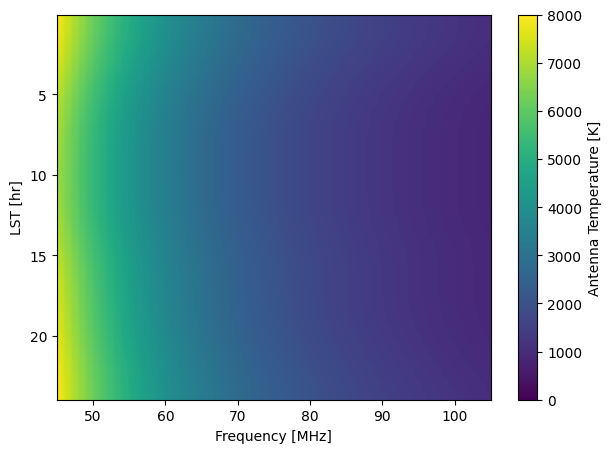

In [3]:
lst, freq, temp = ms.utils.read_hdf5_convolution(
    "../simulations/CSA/CSA_beam_nominal_gsm_no_az_no_tilts_no_mountains.hdf5",
    print_key=True,
)
FLOW = 45
FHIGH = 105
indx = (freq >= FLOW) * (freq <= FHIGH)
freq = freq[indx]
temp = temp[:, indx]
nspec, nfreq = temp.shape
fg_mean = temp.mean(axis=0)  # avg spectrum, fg only

plt.figure(figsize=(7,5))
im = plt.imshow(
    temp, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0, 8000)
plt.colorbar(label="Antenna Temperature [K]")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

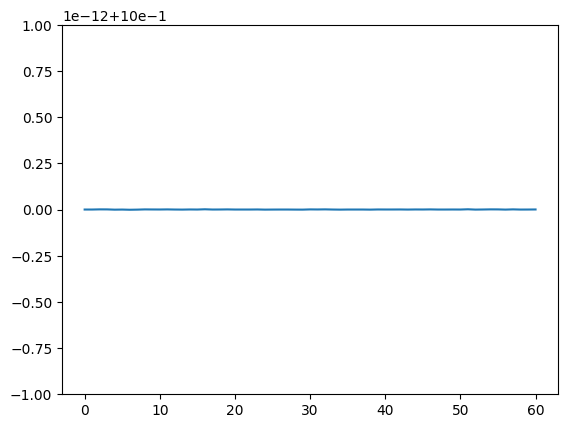

In [4]:
cut = nspec % NBINS
if cut == 0:
    fg_bin = temp.copy()
else:
    fg_bin = temp[:-cut]
fg_bin = fg_bin.reshape(nspec//NBINS, NBINS, nfreq).mean(axis=0)  # this discards the last 6 min integration

plt.figure()
plt.plot(fg_bin.T/fg_mean[:, None])
plt.show()

### Global signal

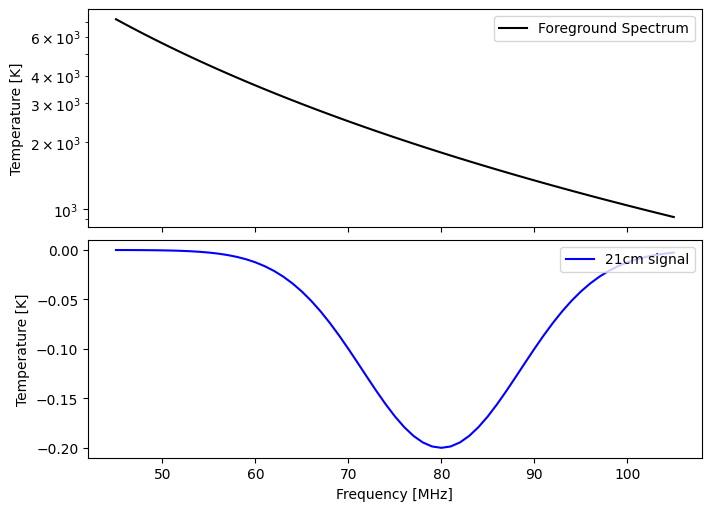

In [5]:
# injected global signal
def gauss(f, a=-0.2, w=20, nu21=80):
    """
    Gaussian in terms of frequency, amplitude, FWHM, and center freq. Default parameters are the ones used in Monsalve et al. 2023b.
    """
    return a * np.exp(-1/2 *((f-nu21) / w)**2 *8*np.log(2))

TRUE_PARAMS = {"a": -0.2, "w": 20, "nu21": 80}
TRUE_T21 = gauss(freq, **TRUE_PARAMS)

fig, axs = plt.subplots(figsize=(7,5), nrows=2, sharex=True, constrained_layout=True)
axs[0].semilogy(freq, fg_mean, label="Foreground Spectrum", c="k")
axs[1].plot(freq, TRUE_T21, label="21cm signal", c="blue")
axs[1].set_xlabel("Frequency [MHz]")
for ax in axs:
    ax.legend(loc="upper right")
plt.setp(axs, ylabel="Temperature [K]")
plt.show()

### Foreground model

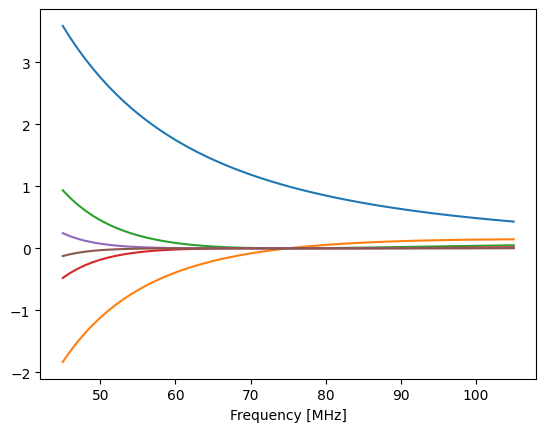

In [6]:
A = ms.utils.design_mat(freq, 6)

plt.figure()
for i in range(A.shape[1]):
    plt.plot(freq, A[:, i])
plt.xlabel("Frequency [MHz]")
plt.show()

# Chromaticity correction

['ant_temp', 'freq', 'lst']


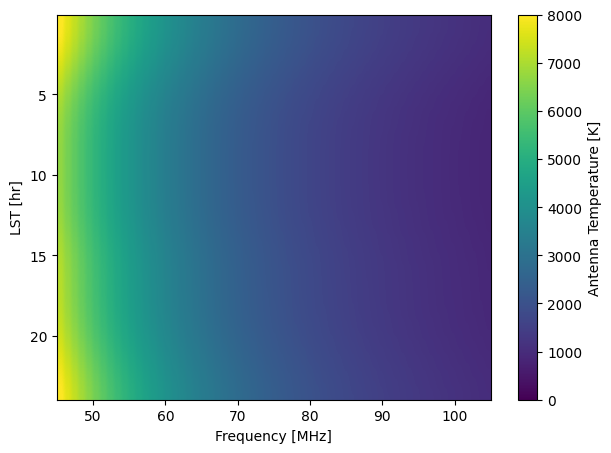

In [7]:
ac_temp = ms.utils.read_hdf5_convolution(
    "../simulations/CSA/CSA_beam_nominal_gsm_no_az_no_tilts_no_mountains_achromatic_75MHz.hdf5",
    print_key=True,
)[-1]

ac_temp = ac_temp[:, indx]


plt.figure(figsize=(7,5))
im = plt.imshow(
    ac_temp, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0, 8000)
plt.colorbar(label="Antenna Temperature [K]")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

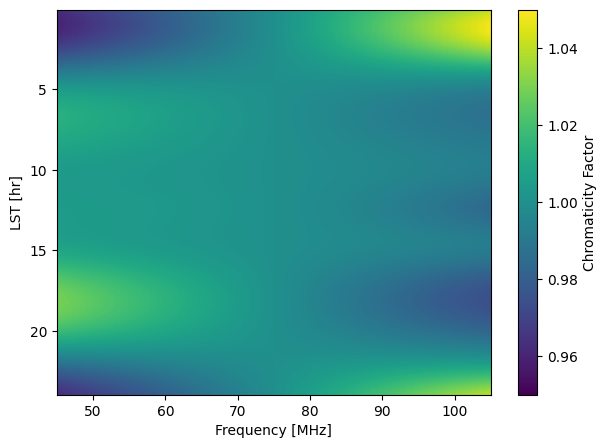

In [8]:
chrom = temp / ac_temp  # chromaticity factor (BF)

plt.figure(figsize=(7,5))
im = plt.imshow(
    chrom, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0.95, 1.05)
plt.colorbar(label="Chromaticity Factor")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

In [9]:
ctemp = (temp+TRUE_T21) / chrom  # = ac temp, the waterfall due to achromatic beam

print(np.allclose(ctemp, ac_temp))
if cut == 0:
    binned = ctemp.copy()
else:
    binned = ctemp[:-cut]
binned = binned.reshape(nspec//NBINS, NBINS, nfreq).mean(axis=0)
chrom_mean = chrom.reshape(nspec//NBINS, NBINS, nfreq).mean(axis=0)
print(chrom_mean.shape)

tint_ratio = (nspec//NBINS) / nspec
noise_75 = 3e-3
t75 = ctemp.mean(axis=0)[freq == 75]
noise, sigma_inv = ms.utils.gen_noise(binned, t75, ref_noise=noise_75, tint_ratio=tint_ratio)

False
(1, 61)


In [10]:
s_christian = np.sqrt(1/sigma_inv[0])
s_raul = (binned[0] / binned[0][freq == 75]) * 3e-3
print(np.max(np.abs(s_christian-s_raul)))
print(np.allclose(s_raul, s_christian))

1.734723475976807e-18
True


In [11]:
noise_raul = np.random.normal(scale=s_raul)

In [12]:
NFG = [5]
#lst_bins = [ms.lstbin.LSTBin(freq, binned[i]+noise[i], np.diag(sigma_inv[i]), NFG[i], chrom=chrom_mean[i]) for i in range(NBINS)]
lst_bins = [ms.lstbin.LSTBin(freq, binned[i]+noise_raul, np.diag(sigma_inv[i]), NFG[i], chrom=chrom_mean[i]) for i in range(NBINS)]

In [13]:
nparticles = 64
bounds = np.array([[-1., 0.], [1., 60.], [45., 105.]]) #XXX
ndims = len(bounds)
sampler = ms.Sampler(nparticles, ndims, bounds, n_cpus=n_cpus) 
results = sampler.run_sampler(lst_bins, add_samples=10000)

Iter: 43it [01:21,  1.90s/it, beta=1, calls=12736, ESS=0.952, logZ=-47, accept=0.239, N=1, scale=1.29, corr=0.708]        
Iter: 157it [00:12, 12.29it/s, beta=1, calls=35008, ESS=0.95, logZ=-47, accept=0.185, N=2, scale=1.49, corr=0.735]


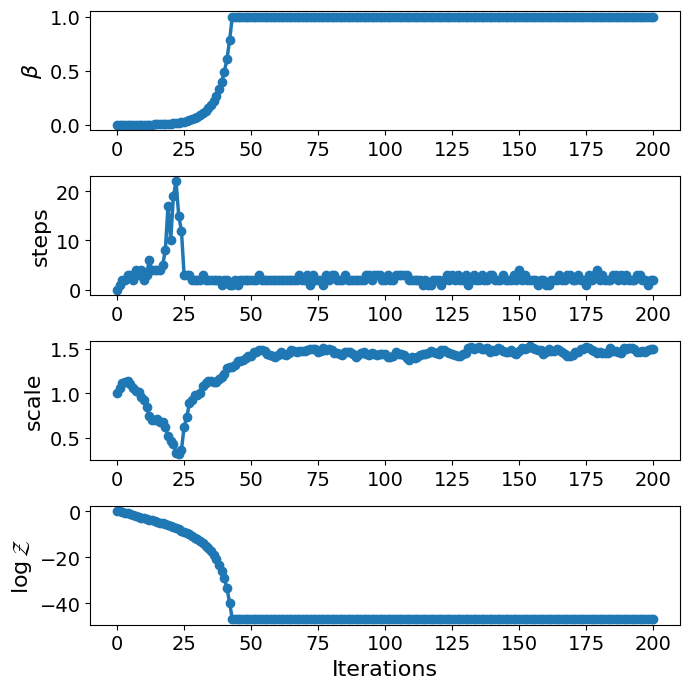

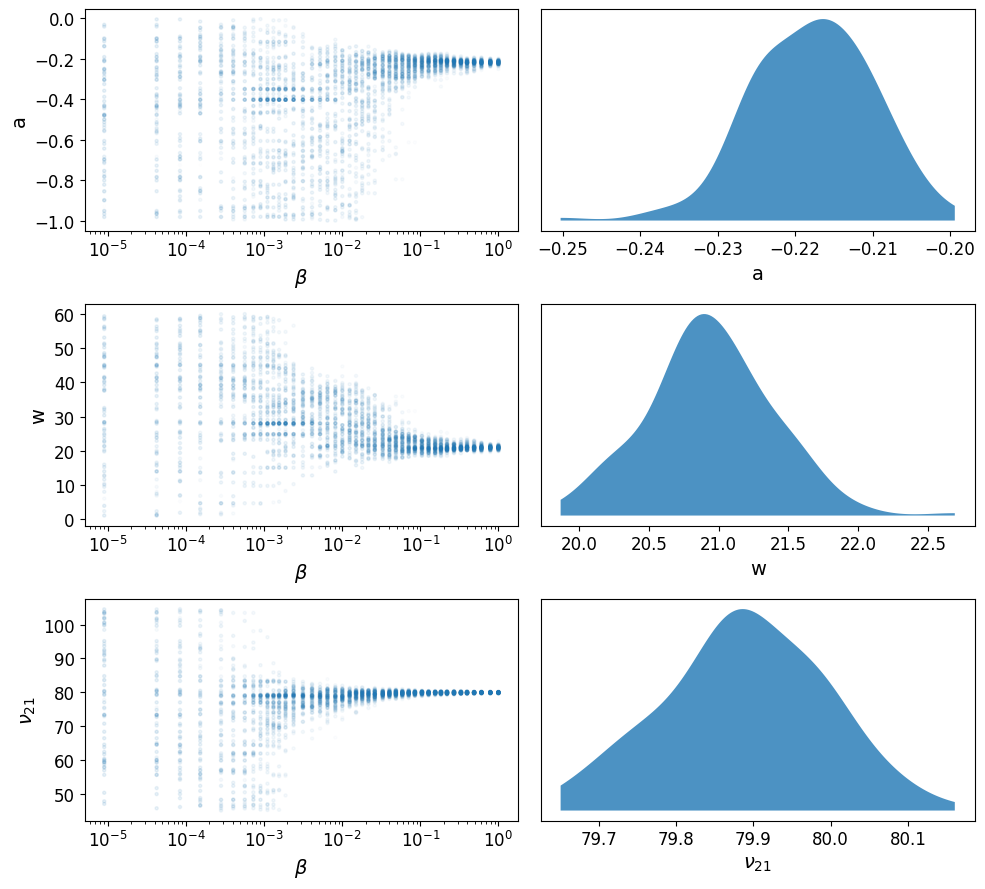

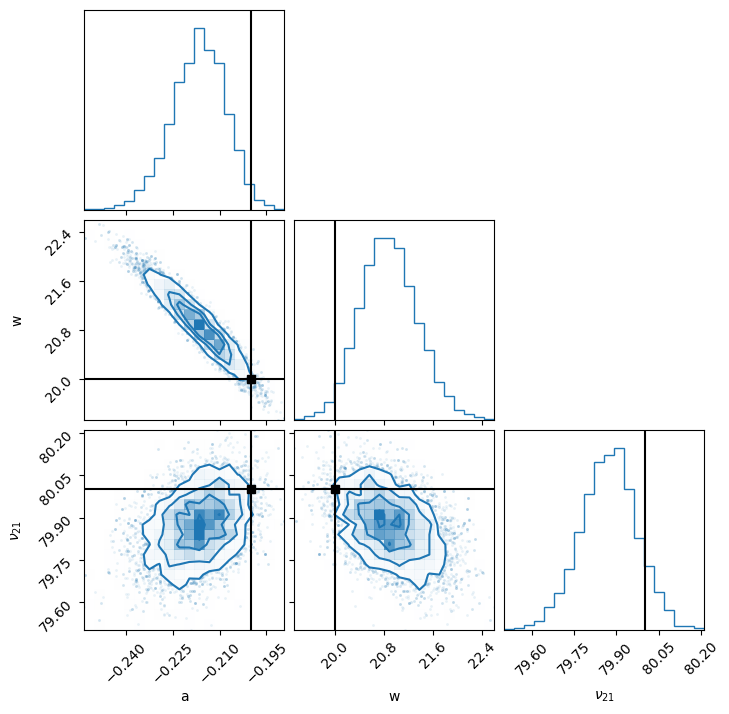

In [14]:
_ = pc.plotting.run(results, width=7, height=7)
labels = ["a", "w", "$\\nu_{21}$"]
_ = pc.plotting.trace(results, labels=labels)
_ = pc.plotting.corner(results, labels=labels, truths=list(TRUE_PARAMS.values()), truth_color="k")

In [15]:
estimated_params = np.mean(results['samples'], axis=0)
std_vals = np.std(results['samples'], axis=0)
print('Mean values = ', estimated_params)
print('Standard deviation values = ', std_vals)
print()
print(100 * np.abs(1 - np.array(list(TRUE_PARAMS.values())) /estimated_params))
print(np.abs(estimated_params-np.array(list(TRUE_PARAMS.values())))/std_vals)

Mean values =  [-0.21665066 20.883167   79.874504  ]
Standard deviation values =  [0.00861651 0.46412715 0.09969382]

[7.68548983 4.22908678 0.15711636]
[1.93241302 1.90285628 1.25881334]


## With my noise

In [16]:
lst_bins = [ms.lstbin.LSTBin(freq, binned[i]+noise[i], np.diag(sigma_inv[i]), NFG[i], chrom=chrom_mean[i]) for i in range(NBINS)]

In [17]:
nparticles = 64
bounds = np.array([[-1., 0.], [1., 60.], [45., 105.]]) #XXX
ndims = len(bounds)
sampler = ms.Sampler(nparticles, ndims, bounds, n_cpus=n_cpus) 
results = sampler.run_sampler(lst_bins, add_samples=10000)

Iter: 44it [01:12,  1.64s/it, beta=1, calls=10560, ESS=0.954, logZ=-42.5, accept=0.257, N=2, scale=1.17, corr=0.554]      
Iter: 157it [00:15, 10.20it/s, beta=1, calls=32576, ESS=0.95, logZ=-42.5, accept=0.184, N=3, scale=1.36, corr=0.623]


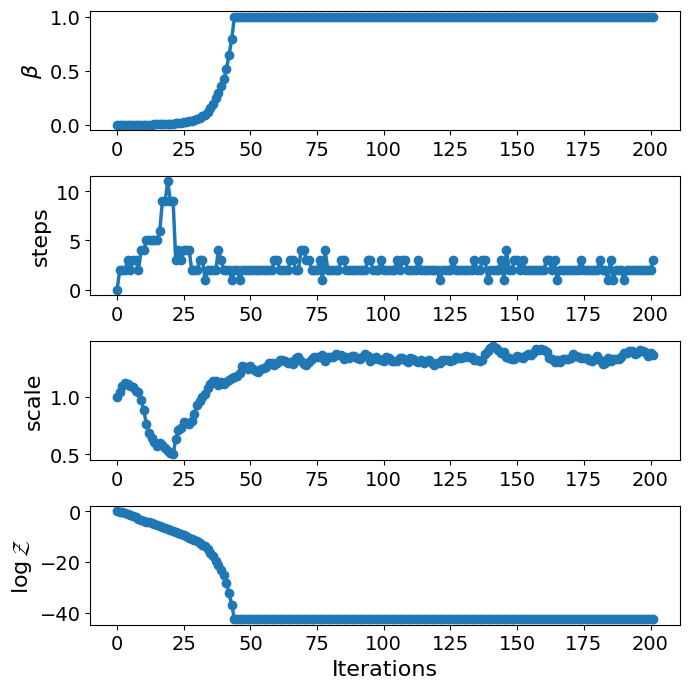

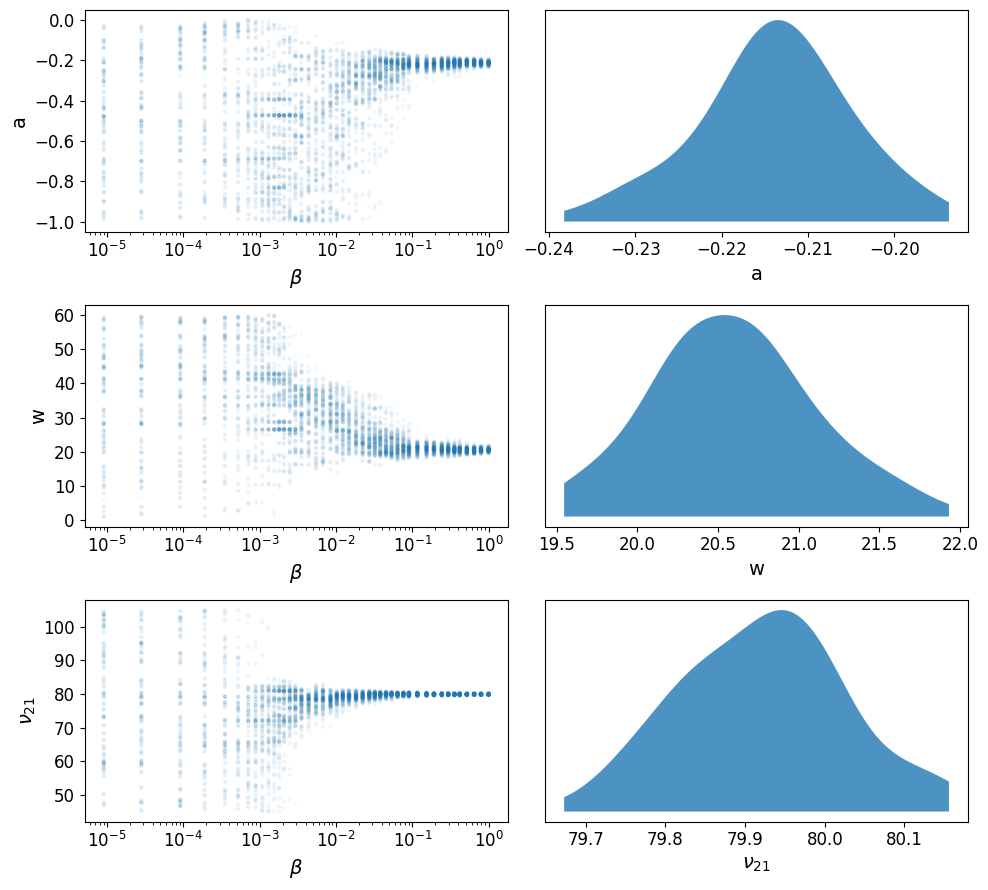

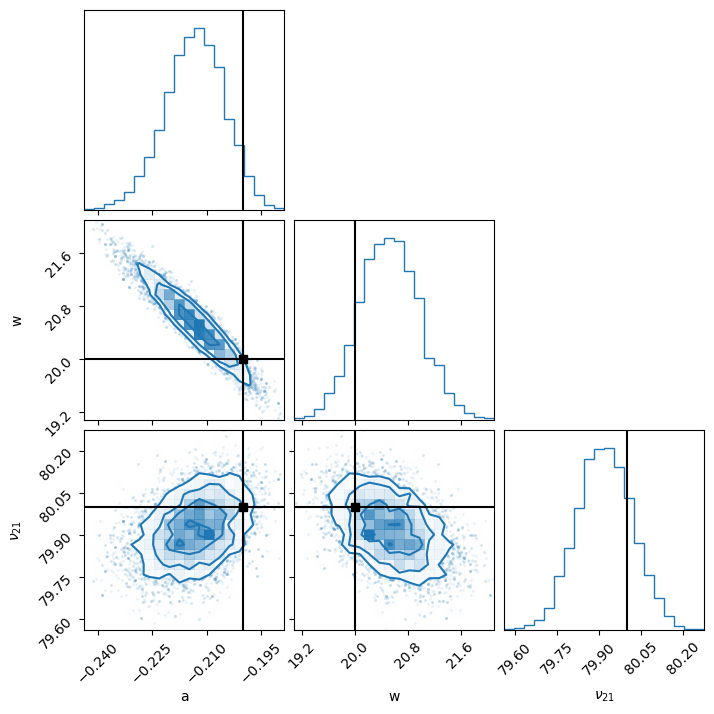

In [18]:
_ = pc.plotting.run(results, width=7, height=7)
labels = ["a", "w", "$\\nu_{21}$"]
_ = pc.plotting.trace(results, labels=labels)
_ = pc.plotting.corner(results, labels=labels, truths=list(TRUE_PARAMS.values()), truth_color="k")

In [19]:
estimated_params = np.mean(results['samples'], axis=0)
std_vals = np.std(results['samples'], axis=0)
print('Mean values = ', estimated_params)
print('Standard deviation values = ', std_vals)
print()
print(100 * np.abs(1 - np.array(list(TRUE_PARAMS.values())) /estimated_params))
print(np.abs(estimated_params-np.array(list(TRUE_PARAMS.values())))/std_vals)

Mean values =  [-0.21321519 20.533348   79.92048   ]
Standard deviation values =  [0.00813938 0.45041355 0.09735031]

[6.19805154 2.59747257 0.09950038]
[1.62361191 1.18412974 0.81685597]


## Check std of noise

In [38]:
seed = 1913
rng = np.random.default_rng(seed)
noise_std = noise_75 * binned / t75 / np.sqrt(tint_ratio)
noise_std = noise_std * np.ones((1000000, 1))
noise = rng.normal(scale=noise_std)

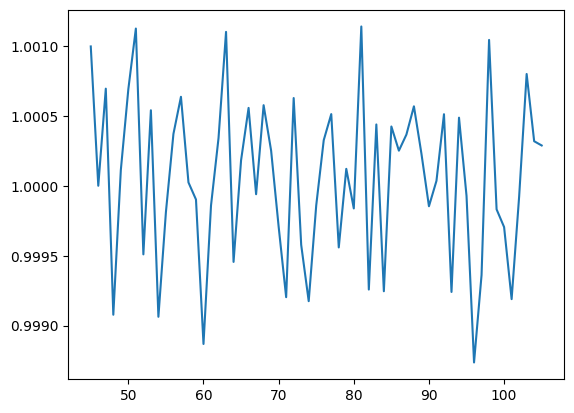

In [44]:
plt.figure()
plt.plot(freq, binned[0]/np.std(noise, axis=0)/t75*noise_75)
plt.show()

## Try different seeds

In [53]:
noise = {}
seeds = [0, 21, 42, 1913, 2024, 16384]
for seed in seeds:
    n, sinv = ms.utils.gen_noise(binned, t75, ref_noise=noise_75, tint_ratio=tint_ratio, seed=seed)
    assert np.allclose(sinv, sigma_inv)
    noise[seed] = n

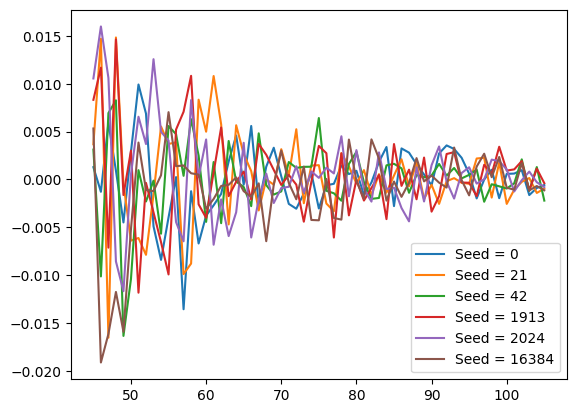

In [55]:
plt.figure()
for k, v in noise.items():
    plt.plot(freq, v[0], label=f"Seed = {k}")
plt.legend()
plt.show()

In [57]:
def print_res(results):
    estimated_params = np.mean(results['samples'], axis=0)
    std_vals = np.std(results['samples'], axis=0)
    print('Mean values = ', estimated_params)
    print('Standard deviation values = ', std_vals)
    print()
    print(100 * np.abs(1 - np.array(list(TRUE_PARAMS.values())) /estimated_params))
    print(np.abs(estimated_params-np.array(list(TRUE_PARAMS.values())))/std_vals)

In [56]:
nparticles = 64
bounds = np.array([[-1., 0.], [1., 60.], [45., 105.]]) #XXX
ndims = len(bounds)
sampler = ms.Sampler(nparticles, ndims, bounds, n_cpus=n_cpus)

In [58]:
all_res = {}
for seed in seeds:
    n = noise[seed]
    lst_bins = [ms.lstbin.LSTBin(freq, binned[i]+n[i], np.diag(sigma_inv[i]), NFG[i], chrom=chrom_mean[i]) for i in range(NBINS)]
    results = sampler.run_sampler(lst_bins, add_samples=10000)
    all_res[seed] = results
    print(f"SEED: {seed}")
    print_res(results)

Iter: 45it [01:16,  1.71s/it, beta=1, calls=15808, ESS=0.996, logZ=-34.1, accept=0.177, N=2, scale=1.13, corr=0.662]       
Iter: 157it [00:14, 11.14it/s, beta=1, calls=38784, ESS=0.95, logZ=-34.1, accept=0.215, N=2, scale=1.25, corr=0.643]

SEED: 0
Mean values =  [-0.19833072 19.718697   79.93733   ]
Standard deviation values =  [0.00660532 0.40301687 0.09197626]

[0.84166726 1.42658215 0.07839622]
[0.25271816 0.69799413 0.6813481 ]



Iter: 45it [01:23,  1.85s/it, beta=1, calls=15680, ESS=0.991, logZ=-40, accept=0.264, N=3, scale=1.03, corr=0.664]         
Iter: 157it [00:11, 14.16it/s, beta=1, calls=37760, ESS=0.95, logZ=-40, accept=0.182, N=2, scale=1.17, corr=0.557]


SEED: 21
Mean values =  [-0.21281347 20.58417    79.891335  ]
Standard deviation values =  [0.00833186 0.4624725  0.09962467]

[6.02098494 2.83795463 0.13601659]
[1.53788818 1.26314406 1.09074856]


Iter: 45it [01:47,  2.39s/it, beta=1, calls=10112, ESS=0.999, logZ=-33.7, accept=0.292, N=2, scale=1.22, corr=0.679]      
Iter: 157it [00:14, 10.77it/s, beta=1, calls=32256, ESS=0.95, logZ=-33.7, accept=0.272, N=3, scale=1.46, corr=0.644]


SEED: 42
Mean values =  [-0.2001332 19.92288   79.98641  ]
Standard deviation values =  [0.00732555 0.43587232 0.0935568 ]

[0.0665579  0.38709176 0.01698782]
[0.01818354 0.17693215 0.14523746]


Iter: 48it [01:25,  1.78s/it, beta=1, calls=8768, ESS=1, logZ=-43.9, accept=0.305, N=2, scale=1.16, corr=0.61]             
Iter: 157it [00:15,  9.98it/s, beta=1, calls=32384, ESS=0.95, logZ=-43.9, accept=0.263, N=2, scale=1.31, corr=0.701]


SEED: 1913
Mean values =  [-0.21353966 20.548962   79.92137   ]
Standard deviation values =  [0.00825675 0.45669535 0.09723469]

[6.34058328 2.67148116 0.09838237]
[1.63982956 1.20203029 0.80864701]


Iter: 45it [01:25,  1.89s/it, beta=1, calls=8896, ESS=0.962, logZ=-38.2, accept=0.231, N=2, scale=1.21, corr=0.74]         
Iter: 157it [00:14, 11.11it/s, beta=1, calls=31168, ESS=0.95, logZ=-38.2, accept=0.255, N=2, scale=1.25, corr=0.719]


SEED: 2024
Mean values =  [-0.20756833 20.3588     80.11009   ]
Standard deviation values =  [0.00825529 0.4641229  0.10013938]

[3.64618844 1.76238714 0.13742608]
[0.91678632 0.77307303 1.09938931]


Iter: 48it [01:22,  1.72s/it, beta=1, calls=10688, ESS=0.998, logZ=-36.8, accept=0.385, N=2, scale=1.24, corr=0.515]       
Iter: 157it [00:13, 11.97it/s, beta=1, calls=34112, ESS=0.95, logZ=-36.8, accept=0.192, N=4, scale=1.29, corr=0.642]

SEED: 16384
Mean values =  [-0.2131703 20.66117   79.88215  ]
Standard deviation values =  [0.00830463 0.4603102  0.09881479]

[6.17830185 3.20005635 0.14753141]
[1.58589934 1.43635545 1.19264801]


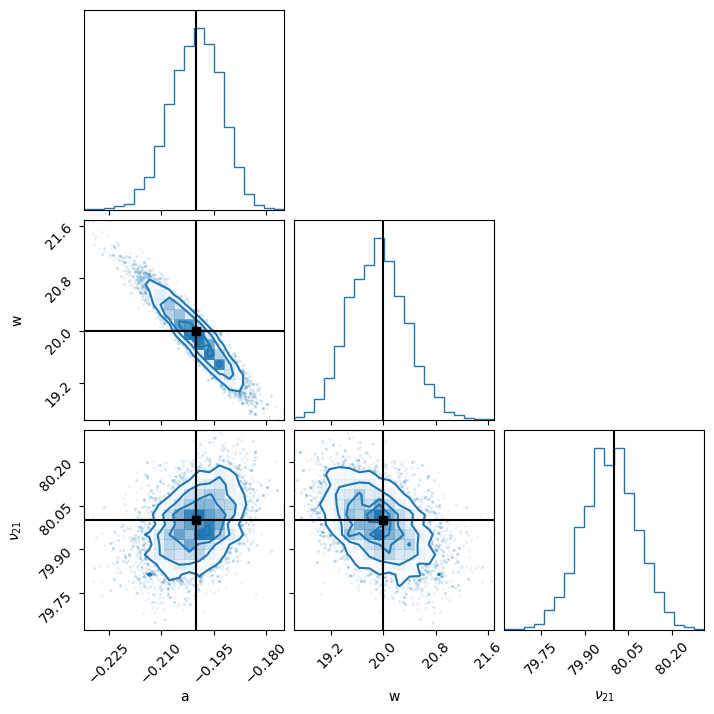

In [62]:
_ = pc.plotting.corner(all_res[42], labels=labels, truths=list(TRUE_PARAMS.values()), truth_color="k")

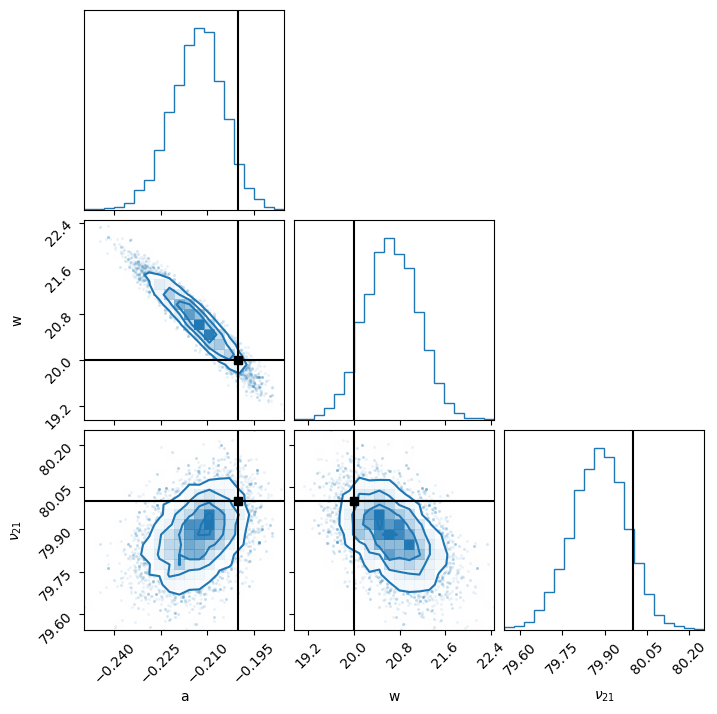

In [61]:
_ = pc.plotting.corner(all_res[16384], labels=labels, truths=list(TRUE_PARAMS.values()), truth_color="k")

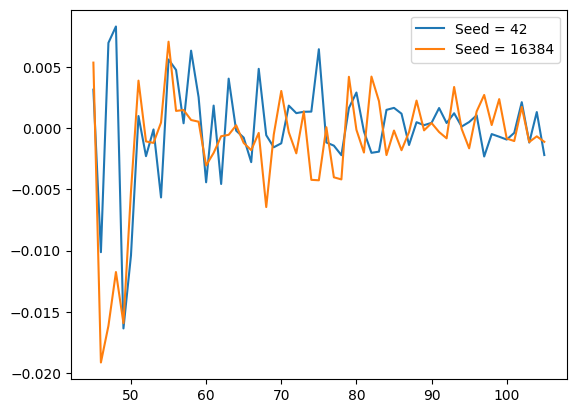

In [63]:
plt.figure()
plt.plot(freq, noise[42][0], label="Seed = 42")
plt.plot(freq, noise[16384][0], label="Seed = 16384")
plt.legend()
plt.show()

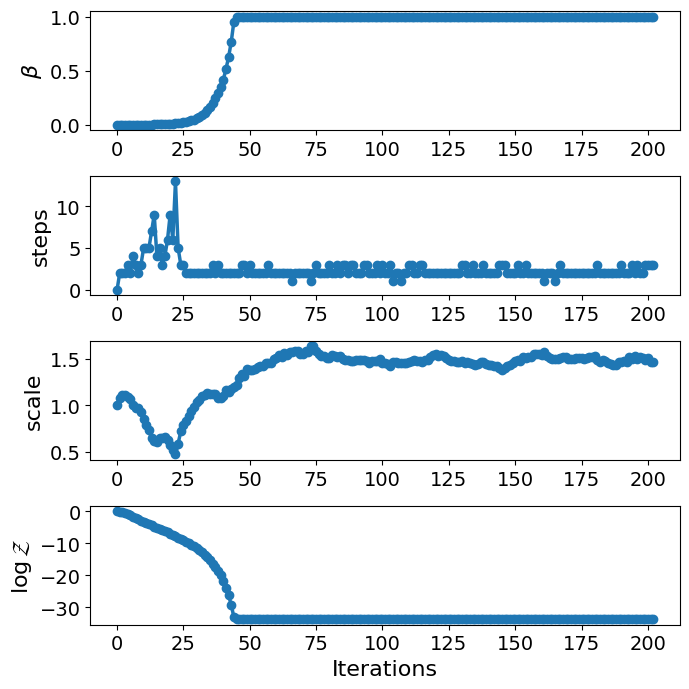

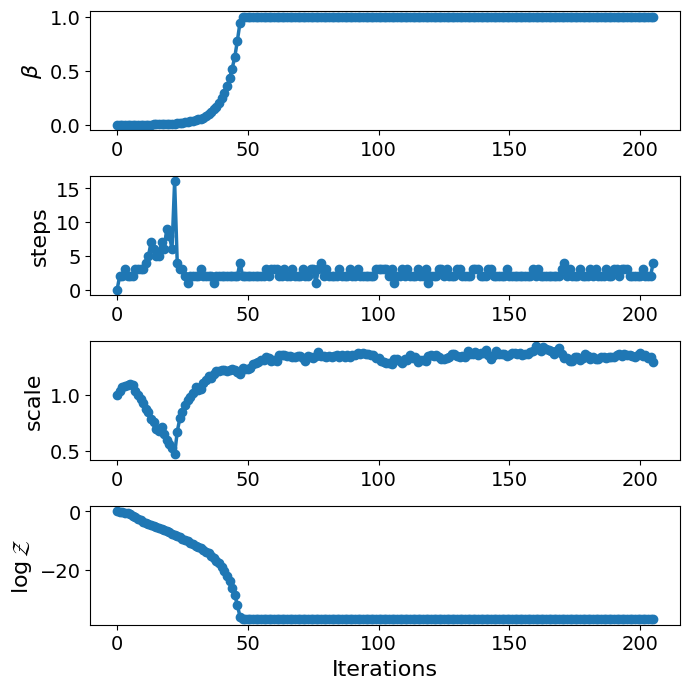

In [64]:
_ = pc.plotting.run(all_res[42], width=7, height=7)
_ = pc.plotting.run(all_res[16384], width=7, height=7)

#_ = pc.plotting.trace(results, labels=labels)

## Vary n_particles and gamma

In [65]:
nparticles = 1000
bounds = np.array([[-1., 0.], [1., 60.], [45., 105.]]) #XXX
ndims = len(bounds)
sampler = ms.Sampler(nparticles, ndims, bounds, n_cpus=n_cpus)

In [66]:
res_NP = {}
for seed in [42, 16384]:
    n = noise[seed]
    lst_bins = [ms.lstbin.LSTBin(freq, binned[i]+n[i], np.diag(sigma_inv[i]), NFG[i], chrom=chrom_mean[i]) for i in range(NBINS)]
    results = sampler.run_sampler(lst_bins, add_samples=0) #XXX
    res_NP[seed] = results
    print(f"SEED: {seed}")
    print_res(results)

Iter: 10it [00:34,  4.15s/it, beta=0.00132, calls=22000, ESS=0.95, logZ=-3.5, accept=0.225, N=3, scale=1.01, corr=0.689]  /home/christian/Documents/research/MIST/mistsim/.venv/lib/python3.10/site-packages/numpy/linalg/linalg.py:2120: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
Iter: 46it [02:54,  3.78s/it, beta=1, calls=97000, ESS=0.992, logZ=-33.3, accept=0.267, N=2, scale=1.15, corr=0.664]      

SEED: 42
Mean values =  [-0.200138 19.933933 79.98266 ]
Standard deviation values =  [0.00740984 0.44488496 0.09379465]

[0.06895374 0.33142853 0.02168172]
[0.01862423 0.14850298 0.18488915]



Iter: 45it [02:31,  3.36s/it, beta=1, calls=102000, ESS=0.973, logZ=-35.4, accept=0.239, N=2, scale=1.13, corr=0.732]      

SEED: 16384
Mean values =  [-0.21331234 20.669922   79.87771   ]
Standard deviation values =  [0.00848491 0.47397256 0.10358856]

[6.24077472 3.24104696 0.15309849]
[1.56894378 1.41341912 1.18055089]


In [ ]:
res_gamma = {}
for seed in [42, 16384]:
    n = noise[seed]
    lst_bins = [ms.lstbin.LSTBin(freq, binned[i]+n[i], np.diag(sigma_inv[i]), NFG[i], chrom=chrom_mean[i]) for i in range(NBINS)]
    results = sampler.run_sampler(lst_bins, add_samples=0) #XXX
    res_gamma[seed] = results
    print(f"SEED: {seed}")
    print_res(results)